In [1]:
import datetime
import time
import tarfile

import boto3
import pandas as pd
import numpy as np
from sagemaker import get_execution_role
import sagemaker
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

sm_boto3 = boto3.client("sagemaker")
sess = sagemaker.Session()
region = sess.boto_session.region_name
#add your bucket here
bucket = 'your bucket here'
print("Using Bucket:" + bucket)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/rickypang/Library/Application Support/sagemaker/config.yaml
Using Bucket:rpmobbucketsagemaker


In [2]:
data = fetch_california_housing()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=0.25, random_state=42
)

trainX = pd.DataFrame(X_train, columns=data.feature_names)
trainX["target"] = y_train

testX = pd.DataFrame(X_test, columns=data.feature_names)
testX["target"] = y_test

In [4]:
trainX.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,4.2143,37.0,5.288235,0.973529,860.0,2.529412,33.81,-118.12,2.285
1,5.3468,42.0,6.364322,1.087940,957.0,2.404523,37.16,-121.98,2.799
2,3.9191,36.0,6.110063,1.059748,711.0,2.235849,38.45,-122.69,1.830
3,6.3703,32.0,6.000000,0.990196,1159.0,2.272549,34.16,-118.41,4.658
4,2.3684,17.0,4.795858,1.035503,706.0,2.088757,38.57,-121.33,1.500


In [5]:
trainX.to_csv("california_housing_train.csv")
testX.to_csv("california_housing_test.csv")

In [6]:
# send data to S3. SageMaker will take training data from s3
trainpath = sess.upload_data(
    path="california_housing_train.csv", bucket=bucket, key_prefix="sagemaker/sklearncontainer"
)

testpath = sess.upload_data(
    path="california_housing_test.csv", bucket=bucket, key_prefix="sagemaker/sklearncontainer"
)

In [7]:
%%writefile script.py

import argparse
import joblib
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor


# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf


if __name__ == "__main__":
    print("extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument("--n-estimators", type=int, default=10)
    parser.add_argument("--min-samples-leaf", type=int, default=3)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="california_housing_train.csv")
    parser.add_argument("--test-file", type=str, default="california_housing_test.csv")
    parser.add_argument(
        "--features", type=str
    )  # in this script we ask user to explicitly name features
    parser.add_argument(
        "--target", type=str
    )  # in this script we ask user to explicitly name the target

    args, _ = parser.parse_known_args()

    print("reading data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print("building training and testing datasets")
    X_train = train_df[args.features.split()]
    X_test = test_df[args.features.split()]
    y_train = train_df[args.target]
    y_test = test_df[args.target]

    # train
    print("training model")
    model = RandomForestRegressor(
        n_estimators=args.n_estimators, min_samples_leaf=args.min_samples_leaf, n_jobs=-1
    )

    model.fit(X_train, y_train)

    # print abs error
    print("validating model")
    abs_err = np.abs(model.predict(X_test) - y_test)

    # print couple perf metrics
    for q in [10, 50, 90]:
        print("AE-at-" + str(q) + "th-percentile: " + str(np.percentile(a=abs_err, q=q)))

    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print("model persisted at " + path)
    print(args.min_samples_leaf)

Overwriting script.py


In [8]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    #add your AWS role below
    role='your role here',
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    metric_definitions=[{"Name": "median-AE", "Regex": "AE-at-50th-percentile: ([0-9.]+).*$"}],
    hyperparameters={
        "n-estimators": 100,
        "min-samples-leaf": 3,
        "features": "MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude Longitude",
        "target": "target",
    },
)

In [9]:
# launch training job, with asynchronous call
sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)

INFO:sagemaker:Creating training-job with name: rf-scikit-2024-04-18-19-29-47-830


2024-04-18 19:29:51 Starting - Starting the training job...
2024-04-18 19:30:07 Starting - Preparing the instances for training...
2024-04-18 19:30:41 Downloading - Downloading input data...
2024-04-18 19:31:27 Training - Training image download completed. Training in progress..2024-04-18 19:31:29,106 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-04-18 19:31:29,108 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-18 19:31:29,148 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-04-18 19:31:29,331 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-18 19:31:29,342 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-18 19:31:29,353 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-18 19:31:29,361 sagemaker-training-toolkit INFO     Invoking user script
T

In [10]:
sklearn_estimator.latest_training_job.wait(logs='None')
artifact= sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name
)['ModelArtifacts']['S3ModelArtifacts']

print('Model Artifact persisted at ', artifact)


2024-04-18 19:31:48 Starting - Preparing the instances for training
2024-04-18 19:31:48 Downloading - Downloading the training image
2024-04-18 19:31:48 Training - Training image download completed. Training in progress.
2024-04-18 19:31:48 Uploading - Uploading generated training model
2024-04-18 19:31:48 Completed - Training job completed
Model Artifact persisted at  s3://sagemaker-us-east-1-730335292805/rf-scikit-2024-04-18-19-29-47-830/output/model.tar.gz


In [ ]:
artifact

In [11]:
from sagemaker.sklearn.model import SKLearnModel

model = SKLearnModel(
    model_data=artifact,
    role='arn:aws:iam::730335292805:role/awssagemaker',
    entry_point="script.py",
    framework_version=FRAMEWORK_VERSION,
)

In [13]:
model

In [12]:
#endpoint deployment
predictor = model.deploy(instance_type="ml.c5.large", initial_instance_count=1)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-04-18-19-33-57-030
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2024-04-18-19-33-58-227
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2024-04-18-19-33-58-227


-----!

In [14]:
features = list(trainX.columns)


In [15]:
testX[0:2].values.tolist()

[[1.6812,
  25.0,
  4.192200557103064,
  1.0222841225626742,
  1392.0,
  3.8774373259052926,
  36.06,
  -119.01,
  0.477],
 [2.5313,
  30.0,
  5.039383561643835,
  1.1934931506849316,
  1565.0,
  2.6797945205479454,
  35.14,
  -119.46,
  0.458]]

In [17]:
new_data = pd.DataFrame(predictor.predict(testX[data.feature_names]))

In [19]:
new_data.head()

,0
0,0.488435
1,0.773406
2,4.748730
3,2.606507
4,2.373223


In [24]:
import matplotlib.pyplot as plt

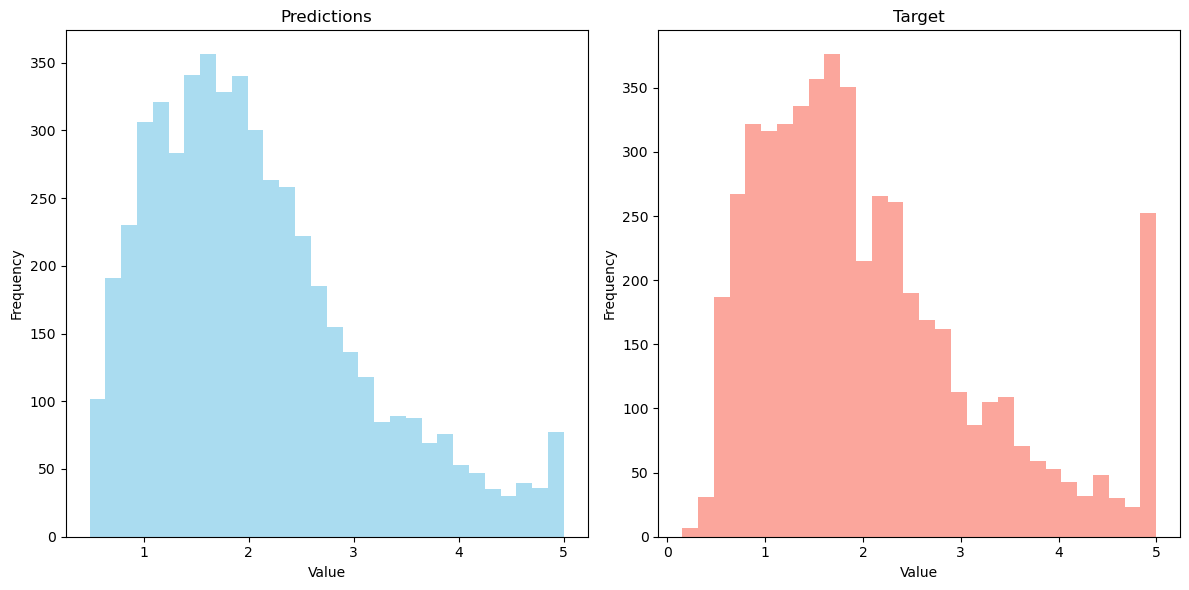

In [28]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# Plot histogram for data1 in the first subplot (axs[0])
axs[0].hist(new_data, bins=30, color='skyblue', alpha=0.7)
axs[0].set_title('Predictions')

# Plot histogram for data2 in the second subplot (axs[1])
axs[1].hist(y_test, bins=30, color='salmon', alpha=0.7)
axs[1].set_title('Target')

# Add labels and title
for ax in axs:
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint)